In [253]:
import cv2
from math import ceil, floor
import numpy as np
import rasterio
from rasterio.mask import mask

from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
from pyproj import Proj, transform
from scipy import ndimage


%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('../utils')
from dataloaders import stretch_8bit

In [2]:
b02 = rasterio.open('../../datasets/onera/images/abudhabi/imgs_1/S2A_OPER_MSI_L1C_TL_MTI__20160120T104345_A003020_T39QZG_B02.tif')
b03 = rasterio.open('../../datasets/onera/images/abudhabi/imgs_1/S2A_OPER_MSI_L1C_TL_MTI__20160120T104345_A003020_T39QZG_B03.tif')
b04 = rasterio.open('../../datasets/onera/images/abudhabi/imgs_1/S2A_OPER_MSI_L1C_TL_MTI__20160120T104345_A003020_T39QZG_B04.tif')

In [3]:
b02_d = b02.read()[0]
b03_d = b03.read()[0]
b04_d = b04.read()[0]

In [5]:
s2b02 = rasterio.open('/media/Drive1/onera_safes/S2A_MSIL1C_20160202T070553_N0201_R063_T39QZG_20160203T213014.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_MTI__20160202T110033_A003206_T39QZG_N02.01/IMG_DATA/S2A_OPER_MSI_L1C_TL_MTI__20160202T110033_A003206_T39QZG_B02.jp2')
s2b03 = rasterio.open('/media/Drive1/onera_safes/S2A_MSIL1C_20160202T070553_N0201_R063_T39QZG_20160203T213014.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_MTI__20160202T110033_A003206_T39QZG_N02.01/IMG_DATA/S2A_OPER_MSI_L1C_TL_MTI__20160202T110033_A003206_T39QZG_B03.jp2')
s2b04 = rasterio.open('/media/Drive1/onera_safes/S2A_MSIL1C_20160202T070553_N0201_R063_T39QZG_20160203T213014.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_MTI__20160202T110033_A003206_T39QZG_N02.01/IMG_DATA/S2A_OPER_MSI_L1C_TL_MTI__20160202T110033_A003206_T39QZG_B04.jp2')


In [7]:
s2b02_d = s2b02.read()[0]
s2b03_d = s2b03.read()[0]
s2b04_d = s2b04.read()[0]

In [8]:
b02.crs, s2b02.crs

(CRS({'init': 'epsg:4326'}), CRS({'init': 'epsg:32639'}))

In [9]:
b02.affine, s2b02.affine

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2961: RasterioDeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2961: RasterioDeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


(Affine(9.40310727259156e-05, 0.0, 54.540252685546875,
        0.0, -9.396766865970705e-05, 24.366488081551143),
 Affine(10.0, 0.0, 799980.0,
        0.0, -10.0, 2700000.0))

In [183]:
"""b02.affine = (Affine(9.40310727259156e-05, 0.0, 54.540252685546875,
        0.0, -9.396766865970705e-05, 24.366488081551143),
 s2b02.affine = Affine(10.0, 0.0, 799980.0,
        0.0, -10.0, 2700000.0))"""

a = b02.affine
s2a = s2b02.affine
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:32639', preserve_units=True)

def get_pix_from_s2(x, y):
    x1,y1 = a * (x,y)
    x2, y2 = transform(inProj,outProj,x1,y1)
    return  ~s2a * (x2,y2)


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2961: RasterioDeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2961: RasterioDeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [241]:
x0, y0 = get_pix_from_s2(0,0)
xn, yn = get_pix_from_s2(b02_d.shape[0], b02_d.shape[1])
print (xn-x0, yn-y0)
print (b02_d.shape)

784.2596855190495 798.1120034877677
(799, 785)


In [12]:
rgb = cv2.merge([stretch_8bit(b02_d),stretch_8bit(b03_d),stretch_8bit(b04_d)])
s2rgb = cv2.merge([stretch_8bit(s2b02_d),stretch_8bit(s2b03_d),stretch_8bit(s2b04_d)])

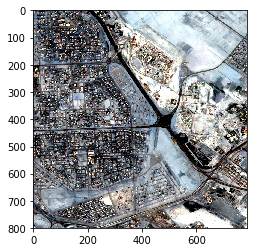

In [30]:
plt.imshow(rgb)

In [250]:
out = np.zeros((rgb.shape[0],rgb.shape[1],3))

for i in range(rgb.shape[0]):
    for j in range(rgb.shape[1]):
        x,y = get_pix_from_s2(rgb.shape[1]-j,rgb.shape[0]-i)
        out[i,j,:] = s2rgb[int(round(y)),int(round(x)),:]


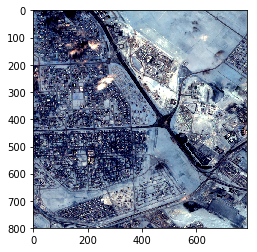

In [254]:
plt.imshow(ndimage.rotate(out.astype(np.uint8), 180))

In [246]:
cv2.imwrite('reprojected.png',out)

True

In [167]:
get_pix_from_s2(0,0), get_pix_from_s2(799, 785)

((5922.762114383571, 61.469605241378304),
 (6707.021799902621, 859.581608729146))

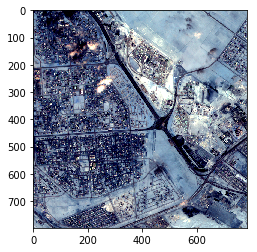

In [169]:
plt.imshow(s2rgb[61:859,5922:6707,:])